# BeautifulSoup + Newspaper 3 이용한 뉴스 클로러 만들기

In [11]:
! pip install beautifulsoup4
! pip install newspaper3k
! pip install konlpy


In [14]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
    urllist= []
    for i in range(1, page_num + 1):
        url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
        news = requests.get(url, headers=headers)

        # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
        soup = BeautifulSoup(news.content, 'html.parser')

        # CASE 1
        news_list = soup.select('.newsflash_body .type06_headline li dl')
        # CASE 2
        news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
        # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
        for line in news_list:
                urllist.append(line.a.get('href'))
    return urllist

In [18]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [15]:
#카테고리 코드 딕셔너리 형태로 저장
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [16]:
#데이터프레임으로 받은 뉴스 저장하는 함수
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
    text_list = []
    for url in urllist:
        article = Article(url, language='ko')
        article.download()
        article.parse()
        text_list.append(article.text)

    #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
    df = pd.DataFrame({'news': text_list})

    #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
    df['code'] = idx2word[str(code)]
    return df

In [19]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


# 데이터 수집 및 저장

In [20]:
#수집하고자 하는 뉴스 카테고리의 코드 입력
code_list = [102, 103, 105]

In [21]:
#카테코리코드 , 날짜, 페이지 수 입력으로 받아 데이터 만들어주는 함수
from multiprocessing import Pool
import random
import time, os

def make_total_data(page_num, code_list, date):
    start = int(time.time())  
    num_cores = 4  
    df = None
    for code in code_list:
        pool = Pool(num_cores)
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')
        pool.close()
        pool.join()
        time.sleep(random.randint(0,1))
        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    print("***run time(sec) :", int(time.time()) - start)
    return df

In [25]:
#2022년 1월 6일에 대해 10페이지까지만 크롤링하며 code_list 안에 있는 카테고리의 뉴스만 수집
df = make_total_data(10, code_list, 20220106)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
***run time(sec) : 438


In [26]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  600


In [29]:
#수집된 데이터 샘플 확인하기
df.sample(5)

,news,code
8,코로나19 바이러스를 99.9% 걸러낼 수 있다고 소개한 에어크좀의 마스크를 기자가...,IT/과학
60,[KBS 전주]오늘 중서부지역을 중심으로 공기가 탁했는데요.현재 일시적으로 대기 질...,생활/문화
64,BMW iX 플로우. /BMW BMW iX 플로우. /BMW\n\n미국 네바다주 라...,IT/과학
50,카카오프렌즈 캐릭터들. 카카오프렌즈 캐릭터들.\n\n카카오 주가 추이 [네이버 증권...,IT/과학
39,지난해 12월19일 경북 포항시 남구 시민운동장에 마련된 신종 코로나바이러스 감염증...,생활/문화


In [30]:
#생성된 데이터 샘플 유실되지 않게 CSV파일로 저장
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
    print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data.csv File Saved!


# 데이터 전처리
- 정제 : Null값, 중복값 제거   
- 토큰화 : 형태소 분석기 사용   
- 불용어 제거 

In [31]:
#크롤링한 데이터 저장한 CSV파일 다시 불러와 데이터 프레임으로 저장
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,사진제공 : 연합뉴스 사진제공 : 연합뉴스\n\n전국자영업자비상대책위원회는 영업시간...,사회
1,경찰은 회삿돈 1880억원을 빼돌린 혐의를 받는 오스템임플란트 직원 이모(45)씨를...,사회
2,기사 섹션 분류 안내\n\n기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다...,사회
3,[앵커]소방청 연결해 평택 물류창고 신축공사장 화재 소식 좀 더 알아보겠습니다.문현...,사회
4,매일경제와 MBN이 GIA 미네르바 바칼로레아와 손잡고 톡톡 튀는 아이디어를 가진 ...,사회


In [32]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_281/3649439000.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0      사진제공  연합뉴스 사진제공  연합뉴스전국자영업자비상대책위원회는 영업시간 제한 조치...
1      경찰은 회삿돈 억원을 빼돌린 혐의를 받는 오스템임플란트 직원 이모씨를 지난 일 검거...
2      기사 섹션 분류 안내기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다 언론사...
3      앵커소방청 연결해 평택 물류창고 신축공사장 화재 소식 좀 더 알아보겠습니다문현주 소...
4      매일경제와 이  미네르바 바칼로레아와 손잡고 톡톡 튀는 아이디어를 가진 전 세계 청...
                             ...                        
595    넥슨코리아대표 이정헌 이하 넥슨는 온라인 액션  마비노기 영웅전에 네 번째 시즌 에...
596    조이시티 제공 조이시티 제공임재형 기자 조이시티가  프리스타일에 플랫폼 상관 없이 ...
597    의  부스 사진하이닉스  의  부스 사진하이닉스 하이닉스가 미국 라스베이거스에서 열...
598    일현지시간 미국 라스베이거스 국제 가전 전시회  에서 열린 기자간담회에 참석한 한종...
599    과학기술정보통신부는 일 개최한  이동통신 주파수 할당계획 토론회에서 대역의  주파수...
Name: news, Length: 600, dtype: object

In [33]:
#Null값 확인
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [34]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  492


In [ ]:
"""#matplotlib 한글폰트 설정하기
# 폰트 설치(nanum 이라는 단어가 포함된 글꼴 패키지 모두 설치) 

$ sudo apt-get install fonts-nanum* 



# 폰트 캐시 삭제 

$ sudo fc-cache -fv 

# matplotlib 패키지 폰트 추가 

$ sudo cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.4/dist-packages/matplotlib/mpl-data/fonts/ttf/ 

$ rm -rf /home/ubuntu/.cache/matplotlib/* 
"""

<AxesSubplot:>

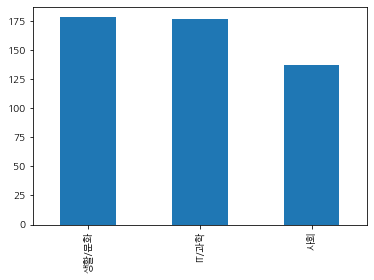

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [36]:
#데이터 실제 개수 출력
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    177
1     사회    137
2  생활/문화    178


In [37]:
# 형태소 분석기 불러오기
#1. kkma
from konlpy.tag import Kkma
from konlpy.utils import pprint
kkma = Kkma()

In [43]:
#2. mecab
from konlpy.tag import Mecab
tokenizer = Mecab()

In [85]:
#3. Hannanum
from konlpy.tag import Hannanum
hannanum = Hannanum()

In [86]:
kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(kkma.morphs(kor_text))
print()
print("---------------------------------")
print()
print(tokenizer.morphs(kor_text))
print()
print("---------------------------------")
print()
print(hannanum.morphs(kor_text))

['밤', '에', '귀가', '하', '더', 'ㄴ', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속', '되', '었', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '하', '어', '수사', '하', '고', '있', '다고', '일', '밝히', '었', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서', '부터', '따라가', '폭행을', '시도', '하', '려', '다그', '아', '도망가', 'ㄴ', '혐의', '를', '받', '는', '다', '피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '었', '으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '더', 'ㄴ', '경찰', '에', '체포', '되', '었', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '하', 'ㄴ', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었', '다']

---------------------------------

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', 

In [46]:
#불용어 제거
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [51]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_kkma(data):
    text_data = []

    for sentence in data:
        temp_data = []
        #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
        #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

    text_data = list(map(' '.join, text_data))

    return text_data

In [52]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_mecab(data):
    text_data = []

    for sentence in data:
        temp_data = []
        #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
        #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

    text_data = list(map(' '.join, text_data))

    return text_data

In [87]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing_han(data):
    text_data = []

    for sentence in data:
        temp_data = []
        #- 토큰화
        temp_data = hannanum.morphs(sentence) 
        #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

    text_data = list(map(' '.join, text_data))

    return text_data

In [73]:
text_data1 = preprocessing_kkma(df['news'])
print(text_data[0])

사진 제공 연합 사진 제공 연합 전국 자영업 자 비상 대책 위원회 영업시간 제한 조치 반발 며 밤 시 이후 가게 간판 불 켜 놓 점 시위 돌입 다고 밝혔 습니다 자 영업자 비대위 어젯밤 일 시 서울 영등포구 카페 앞 에서 회견 열 고 년 동안 정부 정책 옥죄인 자영업 자 영업시간 보장 라며 현실 적 인 손실 보상 실시 라고 요구 습니다 비대위 오 일 까지 일 동안 전국 에서 산발 적 으로 점 시위 를 진행할 예정 며 정부 개선 안 내놓 지 않 으면 더 강력 단체 행동 돌입 겠 다고 밝혔 습니다 비대위 관계자 일 오후 여의도 에서 현실 적 인 손실 보상 요구 집회 를 열 고 국회 까지 행진 계획 라고 말 습니다


In [89]:
text_data2 = preprocessing_mecab(df['news'])
print(text_data[0])

사진 제공 연합 사진 제공 연합 전국 자영업 자 비상 대책 위원회 영업시간 제한 조치 반발 며 밤 시 이후 가게 간판 불 켜 놓 점 시위 돌입 다고 밝혔 습니다 자 영업자 비대위 어젯밤 일 시 서울 영등포구 카페 앞 에서 회견 열 고 년 동안 정부 정책 옥죄인 자영업 자 영업시간 보장 라며 현실 적 인 손실 보상 실시 라고 요구 습니다 비대위 오 일 까지 일 동안 전국 에서 산발 적 으로 점 시위 를 진행할 예정 며 정부 개선 안 내놓 지 않 으면 더 강력 단체 행동 돌입 겠 다고 밝혔 습니다 비대위 관계자 일 오후 여의도 에서 현실 적 인 손실 보상 요구 집회 를 열 고 국회 까지 행진 계획 라고 말 습니다


In [90]:
text_data3 = preprocessing_han(df['news'])
print(text_data[0])

사진 제공 연합 사진 제공 연합 전국 자영업 자 비상 대책 위원회 영업시간 제한 조치 반발 며 밤 시 이후 가게 간판 불 켜 놓 점 시위 돌입 다고 밝혔 습니다 자 영업자 비대위 어젯밤 일 시 서울 영등포구 카페 앞 에서 회견 열 고 년 동안 정부 정책 옥죄인 자영업 자 영업시간 보장 라며 현실 적 인 손실 보상 실시 라고 요구 습니다 비대위 오 일 까지 일 동안 전국 에서 산발 적 으로 점 시위 를 진행할 예정 며 정부 개선 안 내놓 지 않 으면 더 강력 단체 행동 돌입 겠 다고 밝혔 습니다 비대위 관계자 일 오후 여의도 에서 현실 적 인 손실 보상 요구 집회 를 열 고 국회 까지 행진 계획 라고 말 습니다


# 머신러닝 적용하기

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [75]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train1, X_test1, y_train1, y_test1 = train_test_split(text_data1, df['code'], random_state = 0)

In [76]:
print('훈련용 뉴스 기사의 개수 :', len(X_train1))
print('테스트용 뉴스 기사의 개수 : ', len(X_test1))
print('훈련용 레이블의 개수 : ', len(y_train1))
print('테스트용 레이블의 개수 : ', len(y_test1))

훈련용 뉴스 기사의 개수 : 369
테스트용 뉴스 기사의 개수 :  123
훈련용 레이블의 개수 :  369
테스트용 레이블의 개수 :  123


In [77]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train1)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train1)

In [59]:
#자동으로 TF-IDF 벡터로 바꾸는 전처리함수
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

### kkma로 전처리한 데이터

In [64]:
#테스트 데이터 어디에도 속하지 않은 뉴스로 분류기 성능 확인하기
new_sent1 = preprocessing_kkma(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent1)))

['IT/과학']


In [66]:
new_sent = preprocessing_kkma(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [62]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [69]:
new_sent = preprocessing_kkma(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [78]:
y_pred1 = clf.predict(tfidf_vectorizer(X_test1))
print(metrics.classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

       IT/과학       0.81      0.93      0.87        45
          사회       0.92      0.74      0.82        31
       생활/문화       0.87      0.85      0.86        47

    accuracy                           0.85       123
   macro avg       0.87      0.84      0.85       123
weighted avg       0.86      0.85      0.85       123



### mecab으로 전처리한 데이터

In [79]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train2, X_test2, y_train2, y_test2 = train_test_split(text_data2, df['code'], random_state = 0)

In [80]:
print('훈련용 뉴스 기사의 개수 :', len(X_train2))
print('테스트용 뉴스 기사의 개수 : ', len(X_test2))
print('훈련용 레이블의 개수 : ', len(y_train2))
print('테스트용 레이블의 개수 : ', len(y_test2))

훈련용 뉴스 기사의 개수 : 369
테스트용 뉴스 기사의 개수 :  123
훈련용 레이블의 개수 :  369
테스트용 레이블의 개수 :  123


In [81]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train2)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train2)

In [65]:
#테스트 데이터 어디에도 속하지 않은 뉴스로 분류기 성능 확인하기
new_sent1 = preprocessing_mecab(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent1)))

['IT/과학']


In [68]:
#테스트 데이터 어디에도 속하지 않은 뉴스로 분류기 성능 확인하기
new_sent1 = preprocessing_mecab(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [71]:
new_sent = preprocessing_mecab(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [82]:
y_pred2 = clf.predict(tfidf_vectorizer(X_test2))
print(metrics.classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

       IT/과학       0.81      0.93      0.87        45
          사회       0.92      0.74      0.82        31
       생활/문화       0.87      0.85      0.86        47

    accuracy                           0.85       123
   macro avg       0.87      0.84      0.85       123
weighted avg       0.86      0.85      0.85       123



### Hannanum으로 전처리한 데이터

In [91]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train3, X_test3, y_train3, y_test3 = train_test_split(text_data3, df['code'], random_state = 0)

In [92]:
print('훈련용 뉴스 기사의 개수 :', len(X_train3))
print('테스트용 뉴스 기사의 개수 : ', len(X_test3))
print('훈련용 레이블의 개수 : ', len(y_train3))
print('테스트용 레이블의 개수 : ', len(y_test3))

훈련용 뉴스 기사의 개수 : 369
테스트용 뉴스 기사의 개수 :  123
훈련용 레이블의 개수 :  369
테스트용 레이블의 개수 :  123


In [93]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train3)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train3)

In [94]:
#테스트 데이터 어디에도 속하지 않은 뉴스로 분류기 성능 확인하기
new_sent1 = preprocessing_han(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent1)))

['IT/과학']


In [97]:
#테스트 데이터 어디에도 속하지 않은 뉴스로 분류기 성능 확인하기
new_sent = preprocessing_han(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [98]:
new_sent = preprocessing_han(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [99]:
y_pred3 = clf.predict(tfidf_vectorizer(X_test3))
print(metrics.classification_report(y_test3, y_pred3))

              precision    recall  f1-score   support

       IT/과학       0.78      0.96      0.86        45
          사회       0.91      0.65      0.75        31
       생활/문화       0.83      0.81      0.82        47

    accuracy                           0.82       123
   macro avg       0.84      0.80      0.81       123
weighted avg       0.83      0.82      0.82       123



Hannanum 분석기가 제일 성능이 떨어진다!   
분류 시간도 가장 오래 걸렸다.